In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import seaborn as sns

sns.set('talk', font_scale=1.2, rc={'figure.figsize':(8.3,5.2), 'lines.linewidth': 3})

sns.set_style('ticks',
               {'grid.linestyle': 'none', 'axes.edgecolor': '0',
                'axes.linewidth': 1.2, 'legend.frameon': True,
                'xtick.direction': 'out', 'ytick.direction': 'out',
                'xtick.top': True, 'ytick.right': True,
               })


### load already prepared datasets using pickle

In [3]:
d = pickle.load(open("./results/dataset_scaled.p", "rb"))
X = d["X"]
#Y = d["Y"]
Y = d["Y_initial"]

input_shape = [X.shape[-1]]
y_shape = Y.shape[-1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.75, shuffle=True)

/home/laptop/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### create a baseline model
we have three hidden layers and one output layer with the number of neurons as the number of corrector magnets

In [4]:
model_base = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),    
    layers.Dense(y_shape)
])

model_base.compile(
    optimizer='adam',
    loss='mae'
)

early_stopping = EarlyStopping(
    patience = 50,
    min_delta=0.001,
    restore_best_weights=True
)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
history_base = model_base.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    batch_size=256,
    epochs=128,
    callbacks = [early_stopping],
    verbose=False
)

Instructions for updating:
Use tf.cast instead.


### Try batch normalization in cross-validation and dropout

In [6]:
model_cv = keras.Sequential([
    #layers.BatchNormalization(input_shape=input_shape),  # it normalizes the whole input
    layers.Dense(1024, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),

    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    
    layers.Dense(y_shape)
])

model_cv.compile(
    optimizer='adam',
    loss='mae'
)

early_stopping = EarlyStopping(
    patience = 50,
    min_delta=0.001,
    restore_best_weights=True
)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
history = model_cv.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    batch_size=256,
    epochs=128,
    callbacks = [early_stopping],
    verbose=False
)

### compare to simple models
though we have less overfitting with the dropout, the score is not pushed down

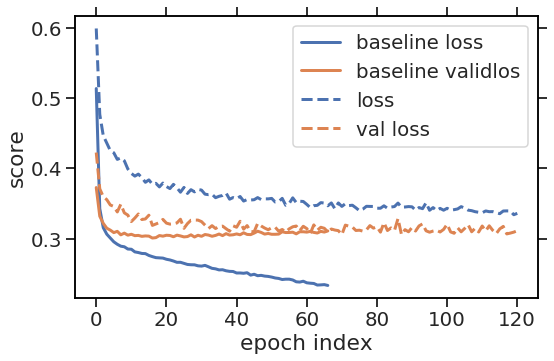

In [8]:
history_df_base = pd.DataFrame(history_base.history)
history_df = pd.DataFrame(history.history)

plt.plot(history_df_base["loss"], label="baseline loss")
plt.plot(history_df_base["val_loss"], label="baseline validlos")

plt.plot(history_df["loss"], c="C0", ls="--", label='loss')
plt.plot(history_df["val_loss"], c="C1", ls="--", label='val loss')

plt.xlabel("epoch index")
plt.ylabel("score")

plt.legend()
#plt.ylim(0,0.1)

### Trying with pre-defined corrector clusters

In [9]:
d_cluster = pickle.load(open("./results/dataset_clustered.p", "rb"))
X = d_cluster["X"]
#Y = d_cluster["Y"] #scaled
Y = d["Y_initial"]

input_shape = [X.shape[-1]]
y_shape = Y.shape[-1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.75, shuffle=True)

In [10]:
model = keras.Sequential([
    #layers.BatchNormalization(input_shape=input_shape),  # it normalizes the whole input
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dropout(0.2),

    #layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    
    #layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),

    #layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    
    layers.Dense(y_shape)
])

model.compile(
    optimizer='adam',
    loss='mae'
)

early_stopping = EarlyStopping(
    patience = 50,
    min_delta=0.001,
    restore_best_weights=True
)

In [11]:
history1 = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    batch_size=256,
    epochs=512,
    callbacks = [early_stopping],
    verbose=False
)

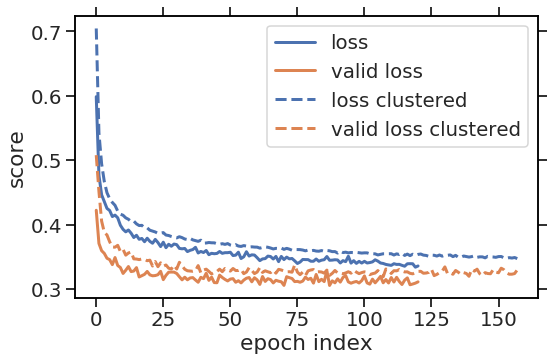

In [12]:
history_df1 = pd.DataFrame(history1.history)

plt.plot(history_df['loss'], c="C0", label="loss")
plt.plot(history_df['val_loss'], c="C1", label="valid loss")
plt.plot(history_df1['loss'], c="C0",ls="--", label="loss clustered")
plt.plot(history_df1['val_loss'], c="C1",ls="--", label="valid loss clustered")

#plt.ylim(0.02,0.1)
plt.xlabel("epoch index")
plt.ylabel("score")

plt.legend()

## Validation on test data

In [13]:
from correction import *

In [14]:
def prepare_test_data(stopband0, twiss):
    
    df = pd.DataFrame()

    df['stopband_initial'] = [np.mean(stopband0)] 

    bpmx = twiss[twiss["keyword"].str.contains("hmonitor")][["name", "betx"]]
    bpmy = twiss[twiss["keyword"].str.contains("vmonitor")][["name", "bety"]]

    for name, beta in zip(bpmx["name"], bpmx["betx"]):
        df[name[:-2]] = [beta]

    for name, beta in zip(bpmy["name"], bpmy["bety"]):
        df[name[:-2]] = [beta]
        
    return df

### get errorset

In [15]:
Qx, Qy = 18.75, 18.8
dk = 1e-3

madx = Madx(stdout=False)
twiss, twiss_cold_arr = lattice_setup(Qx,Qy, madx)
twiss_err = add_quadrupole_errors(twiss, dk, madx, 0, store_errors=False)

theta = np.zeros(24)
stopband0 = find_stopband(theta, twiss_cold_arr, madx)

df = prepare_test_data(stopband0, twiss_err)

# Results with clustering

### transform test data

In [16]:
features = [name for name in X.columns.tolist() if "median" not in name and "Cluster" not in name]

X_test = df[features]
X_test_scaled = d_cluster['scaler_x'].transform(X_test)
X = d_cluster['X']

### get clusters

In [17]:
kmeans = d_cluster["kmeans"]
cluster = kmeans.predict(X_test_scaled)[0]

median_features = [name for name in X.columns.tolist() if "median" in name]
Y_pred = np.array(X[X['Cluster'] == cluster][median_features].mean())

Y_pred = d['scaler_y'].transform(Y_pred.reshape(1, -1))[0] / 1000

In [18]:
madx.input(matching(Qx, Qy))
qx,qy = set_quads(Y_pred, madx)
print(f"tunes are {qx} {qy}")
twiss_cluster = madx.table.twiss.dframe()

stopband_clustered = find_stopband(Y_pred, twiss_cold_arr, madx)

tunes are 18.74999810092002 18.800040533450815


### get neural network prediction from clustered data

In [19]:
# now predict using the data bout clusters
cluster_names = [f"{name}_median" for name in Y.columns.tolist()]
X_cluster = pd.DataFrame([Y_pred], columns=cluster_names)
X_cluster["Cluster"] = [cluster]

X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X = X_test.join(X_cluster)

Y_pred_cl_nw = model.predict(X)[0]
Y_pred_cl_nw = d['scaler_y'].transform(Y_pred_cl_nw.reshape(1, -1))[0] / 1000

In [20]:
madx.input(matching(Qx, Qy))
qx,qy = set_quads(Y_pred_cl_nw, madx)
print(f"tunes are {qx} {qy}")
twiss_cluster_nw = madx.table.twiss.dframe()

stopband_clustered_nw = find_stopband(Y_pred_cl_nw, twiss_cold_arr, madx)

tunes are 18.75208827727889 18.799387326468096


# Without clustering

In [21]:
d = pickle.load(open("./results/dataset_scaled.p", "rb"))
X_test = df[features]
X_test_scaled = d['scaler_x'].transform(X_test)

Y_pred_base = model_cv.predict(X_test_scaled)[0]
Y_pred_base = d['scaler_y'].transform(Y_pred_base.reshape(1,-1))[0] / 1000

In [22]:
madx.input(matching(Qx, Qy))
qx,qy = set_quads(Y_pred_base, madx)
print(f"tunes are {qx} {qy}")
twiss_base = madx.table.twiss.dframe()

stopband_model = find_stopband(Y_pred_base, twiss_cold_arr, madx)

tunes are 18.74909551754677 18.80039638412881


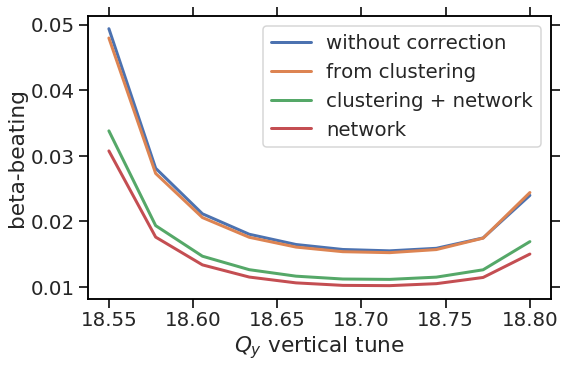

In [23]:
qy = np.linspace(18.55, Qy, 10)
plt.plot(qy, stopband0, label="without correction")
plt.plot(qy, stopband_clustered, label="from clustering")
plt.plot(qy, stopband_clustered_nw, label= "clustering + network")
plt.plot(qy, stopband_model, label= "network")

plt.legend()

plt.xlabel(r"$Q_y$ vertical tune")
plt.ylabel("beta-beating")

plt.show();

In [24]:
Qy = 18.7

madx.input(matching(Qx, Qy))
qx,qy = set_quads(Y_pred_base, madx)
twiss_base = madx.table.twiss.dframe()

madx.input(matching(Qx, Qy))
qx,qy = set_quads(theta, madx)
twiss_err = madx.table.twiss.dframe()

madx = Madx(stdout=False)
twiss, twiss_cold_arr = lattice_setup(Qx,Qy, madx)

## beta-beating across the ring for Qy = 18.7

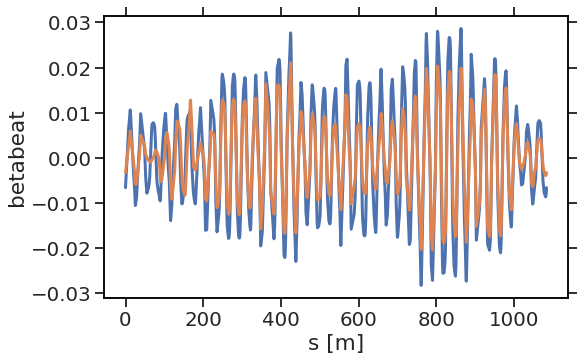

In [25]:
plt.plot(twiss_err['s'], twiss_err['bety'] / twiss['bety'] - 1)
plt.plot(twiss_base['s'], twiss_base['bety'] / twiss['bety'] - 1)

#plt.xlim(0, 1083.6 / 3)

plt.xlabel("s [m]")
plt.ylabel("betabeat")

plt.show();

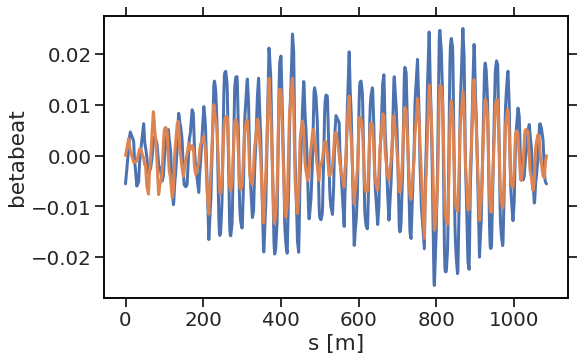

In [26]:
plt.plot(twiss_err['s'], twiss_err['betx'] / twiss['betx'] - 1)
plt.plot(twiss_base['s'], twiss_base['betx'] / twiss['betx'] - 1)

#plt.xlim(0, 1083.6 / 3)

plt.xlabel("s [m]")
plt.ylabel("betabeat")

plt.show();